In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import ipywidgets as widgets  # not used, for future
from IPython.display import display
import nglview as nv
from io import StringIO
import time
import pandas as pd

In [2]:
def pos2pdb(positions):
    pdb_str = "MODEL\n"
    for i, pos in enumerate(positions):
        pdb_str += f"ATOM  {i+1:5d}  CA  ALA A{i+1:4d}    {pos[0]:8.3f}{pos[1]:8.3f}{0.0:8.3f}  1.00  0.00           C  \n"
    pdb_str += "ENDMDL\n"
    return pdb_st

In [3]:
import time
start_time = time.time()

id = 24142611
def student_id_to_initial_T(id):
 r = id % 10000000
 return (r / 10000000) * 6 +1

T = student_id_to_initial_T(id)
N = 100  # Number of atoms
d = 2  # a 2D system
rho = 0.8  # The (reduced units) density (in 2D)

T0 = T  # Reduced temperature (in reduced units)
Ti = T0  # Initial Temperature (in reduced units)
# the Interatomic Potential (a special case of a Materials Relation)
epsilon = 1.0
sigma = 1.0
dt = 0.0025
max_steps = 2000
print(T0)



3.4564084


In [4]:
# From the equation for the density. 
L = np.sqrt(N / rho)  # length of the simulation box (supercell) side.

a = L / np.sqrt(N)  # Lattice parameter 

Lx, Ly = L, L  # Simulation box size in x and y

# Create the lattice positions
positions = []
for i in range(int(np.sqrt(N))):
    for j in range(int(np.sqrt(N))):
        x = i * a
        y = j * a
        positions.append([x, y])

positions = np.array(positions)

# Generate random velocities for the particles
velocities = np.random.randn(N, d)
m = 1
k_B =1

# Rescale velocities to match the desired initial temperature [see lecture notes]
v_s = np.sum(velocities**2, axis=1)
ke = 0.5 * np.sum(v_s)
ke_target = N * T0
scaling_factor = np.sqrt(ke_target / ke)
velocities *= scaling_factor
# 定义温度计算函数
def calculate_temperature(velocities, m, k_B):
    # 计算每个粒子的速度平方和
    v_squared = np.sum(velocities**2, axis=1)
    ke = 0.5 * np.sum(v_squared)  # 总动能
    temperature = (2 * ke) / (d * N * k_B)
    return temperature

# 调用函数计算温度
temperature = calculate_temperature(velocities, m, k_B)
print(f"Calculated Temperature: {temperature:}")

Calculated Temperature: 3.4564084000000004


In [5]:
def compute_force(positions, epsilon, sigma):   
    
    # return an array (same shape as the positions numpy array) 
    # but all elements are zero
    forces = np.zeros_like(positions) 
    
    pot_energy = 0

    for i in range(N):        
        for j in range(i + 1, N):            
            rij = positions[i] - positions[j]                        
            rij = rij - np.round(rij / L) * L  # Periodic boundary conditions
            r=np.sqrt(rij.dot(rij))
            if r<0.2: # avoid blow out due to too close, or overlaping atoms
                r=0.2    
            # force2 is the magnitude of the force!    
            force2 = 48 * epsilon * np.power(sigma, 12) / np.power(r, 13)- 24 * epsilon * np.power(sigma, 6) / np.power(r, 7)  
            force=force2*rij/r                        
            forces[i] += force            
            forces[j] -= force    
          
            # the pot energy:
            pe = 4 * epsilon * (np.power(sigma/r, 12) - np.power(sigma/r, 6))
            if pe > 1000:  # in case atoms are overlapping...
                print('posible overlap - warning', i, j, r, rij, pe)
            pot_energy = pot_energy + pe

    return forces, pot_energy

In [6]:
def compute_kinetic_energy(velocities):
    kinetic_energy = 0.5 * np.sum(velocities**2)
    temperature = kinetic_energy / N  # Equipartition Theorem in 2D!
    return kinetic_energy, temperature

In [7]:
def update_positions(positions, velocities, forces, epsilon, sigma, dt):

    # First update positions based on current velocities and forces (Verlet step 1) or the  **first half-step of the Velocity Verlet method**
    positions += velocities * dt + 0.5 * forces * dt ** 2
    
    positions %= L  #  periodic boundary conditions
    
    # Calculate new forces after updating positions
    new_forces, pot_energy = compute_force(positions, epsilon, sigma)
    
    # Update velocities (Verlet step 2 or second half step)
    velocities += 0.5 * (forces + new_forces) * dt

    return positions, velocities, new_forces, pot_energy

In [8]:
# Initialize forces
forces, pot_energy = compute_force(positions, epsilon, sigma)

# Initialize an array to store positions for all steps
all_positions = np.zeros((max_steps, N, 2))

In [9]:
stats=[] # stores the thermodynamical statistical variables

with open("simulation_results_1000.dat", "w") as f:
    f.write('#Step   Etot   PotE Ktot  T\n')
    
    for step in range(max_steps):
        positions, velocities, forces, pot_energy = update_positions(positions, velocities, forces, epsilon, sigma, dt)
        kinetic_energy, temperature = compute_kinetic_energy(velocities)
        tot_energy = pot_energy + kinetic_energy
        
        all_positions[step] = positions
                
        f.write(f"{step} {tot_energy/N:.6f} {pot_energy/N:.6f}  {kinetic_energy/N:.6f} {temperature:.2f}\n")
        stats.append([step, tot_energy/N, pot_energy/N, kinetic_energy/N, temperature])
        
stats = np.array(stats)


In [10]:
print(temperature)

end_time = time.time()
execution_time = end_time - start_time
print(f"time: {execution_time:.4f} s")


2.5052689471760776
time: 86.4735 s


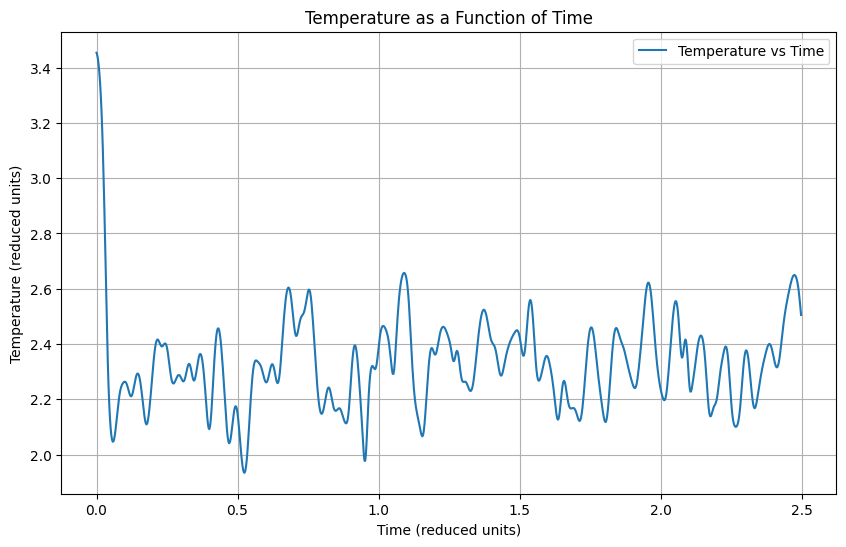

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(stats[:, 0] * dt, stats[:, 4], label='Temperature vs Time')  # stats[:, 0] 为时间步长，stats[:, 4] 为温度
plt.xlabel('Time (reduced units)')
plt.ylabel('Temperature (reduced units)')
plt.title('Temperature as a Function of Time')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
stats_df = pd.DataFrame(stats, columns=['Step', 'Total Energy', 'Potential Energy', 'Kinetic Energy', 'Temperature'])

expectation_value_T = stats_df['Temperature'].mean()
print(f"Expectation of temperature: {expectation_value_T:.4f}")

Expectation of temperature: 2.3306


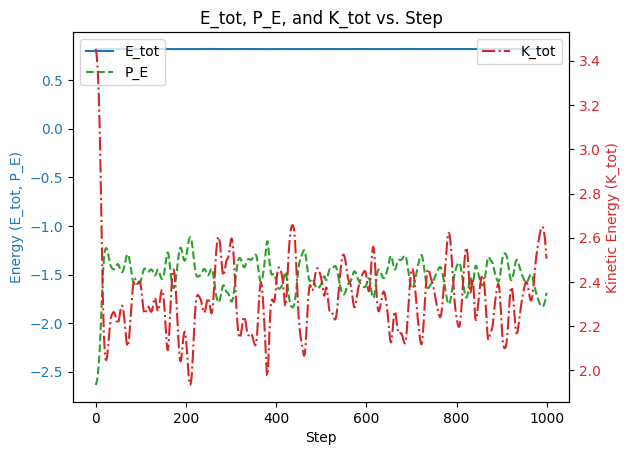

In [13]:
step = stats[:, 0]  
E_tot = stats[:, 1]  
P_E = stats[:, 2]  
K_tot = stats[:, 3]  
T     = stats[:,4]

fig, ax1 = plt.subplots()

ax1.set_xlabel('Step')
ax1.set_ylabel('Energy (E_tot, P_E)', color='tab:blue')
ax1.plot(step, E_tot, label='E_tot', color='tab:blue', linestyle='-')
ax1.plot(step, P_E, label='P_E', color='tab:green', linestyle='--')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

# Create a second y-axis (y2) sharing the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('Kinetic Energy (K_tot)', color='tab:red')
ax2.plot(step, K_tot, label='K_tot', color='tab:red', linestyle='-.')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')

# Add a title and display the plot
plt.title('E_tot, P_E, and K_tot vs. Step')
plt.show()